## Import packages

In [2]:
import pandas as pd
import json

import missingno as msno

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




## Import challenge data into dataframe

In [3]:
# Load JSON data from file
with open('data/challenge_set.json', 'r') as file: # Replace with local dataset path
    data = json.load(file)

# Initialize an empty list to collect all track data
all_tracks = []

# Loop through each playlist in the dataset
for playlist in data['playlists']:
    for track in playlist['tracks']:
        # Add playlist-level information to each track record
        track_info = {
            'playlist_name': playlist.get('name', 'Unknown'),
            'playlist_pid': playlist['pid'],
            'playlist_num_tracks': playlist['num_tracks'],
            'track_pos': track['pos'],
            'artist_name': track['artist_name'],
            'track_uri': track['track_uri'],
            'artist_uri': track['artist_uri'],
            'track_name': track['track_name'],
            'album_uri': track['album_uri'],
            'duration_ms': track['duration_ms'],
            'album_name': track['album_name']
        }
        all_tracks.append(track_info)

# Convert the list of track dictionaries to a DataFrame and reassign dataframe to new variable name
df_spotify = pd.DataFrame(all_tracks)
spotify = df_spotify

# Display the first few rows of the DataFrame to verify
#print(df_spotify.head())

----

### Check for missing data and nan-values

In [4]:
# Dataframe Column Names
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281000 entries, 0 to 280999
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   playlist_name        281000 non-null  object
 1   playlist_pid         281000 non-null  int64 
 2   playlist_num_tracks  281000 non-null  int64 
 3   track_pos            281000 non-null  int64 
 4   artist_name          281000 non-null  object
 5   track_uri            281000 non-null  object
 6   artist_uri           281000 non-null  object
 7   track_name           281000 non-null  object
 8   album_uri            281000 non-null  object
 9   duration_ms          281000 non-null  int64 
 10  album_name           281000 non-null  object
dtypes: int64(4), object(7)
memory usage: 23.6+ MB


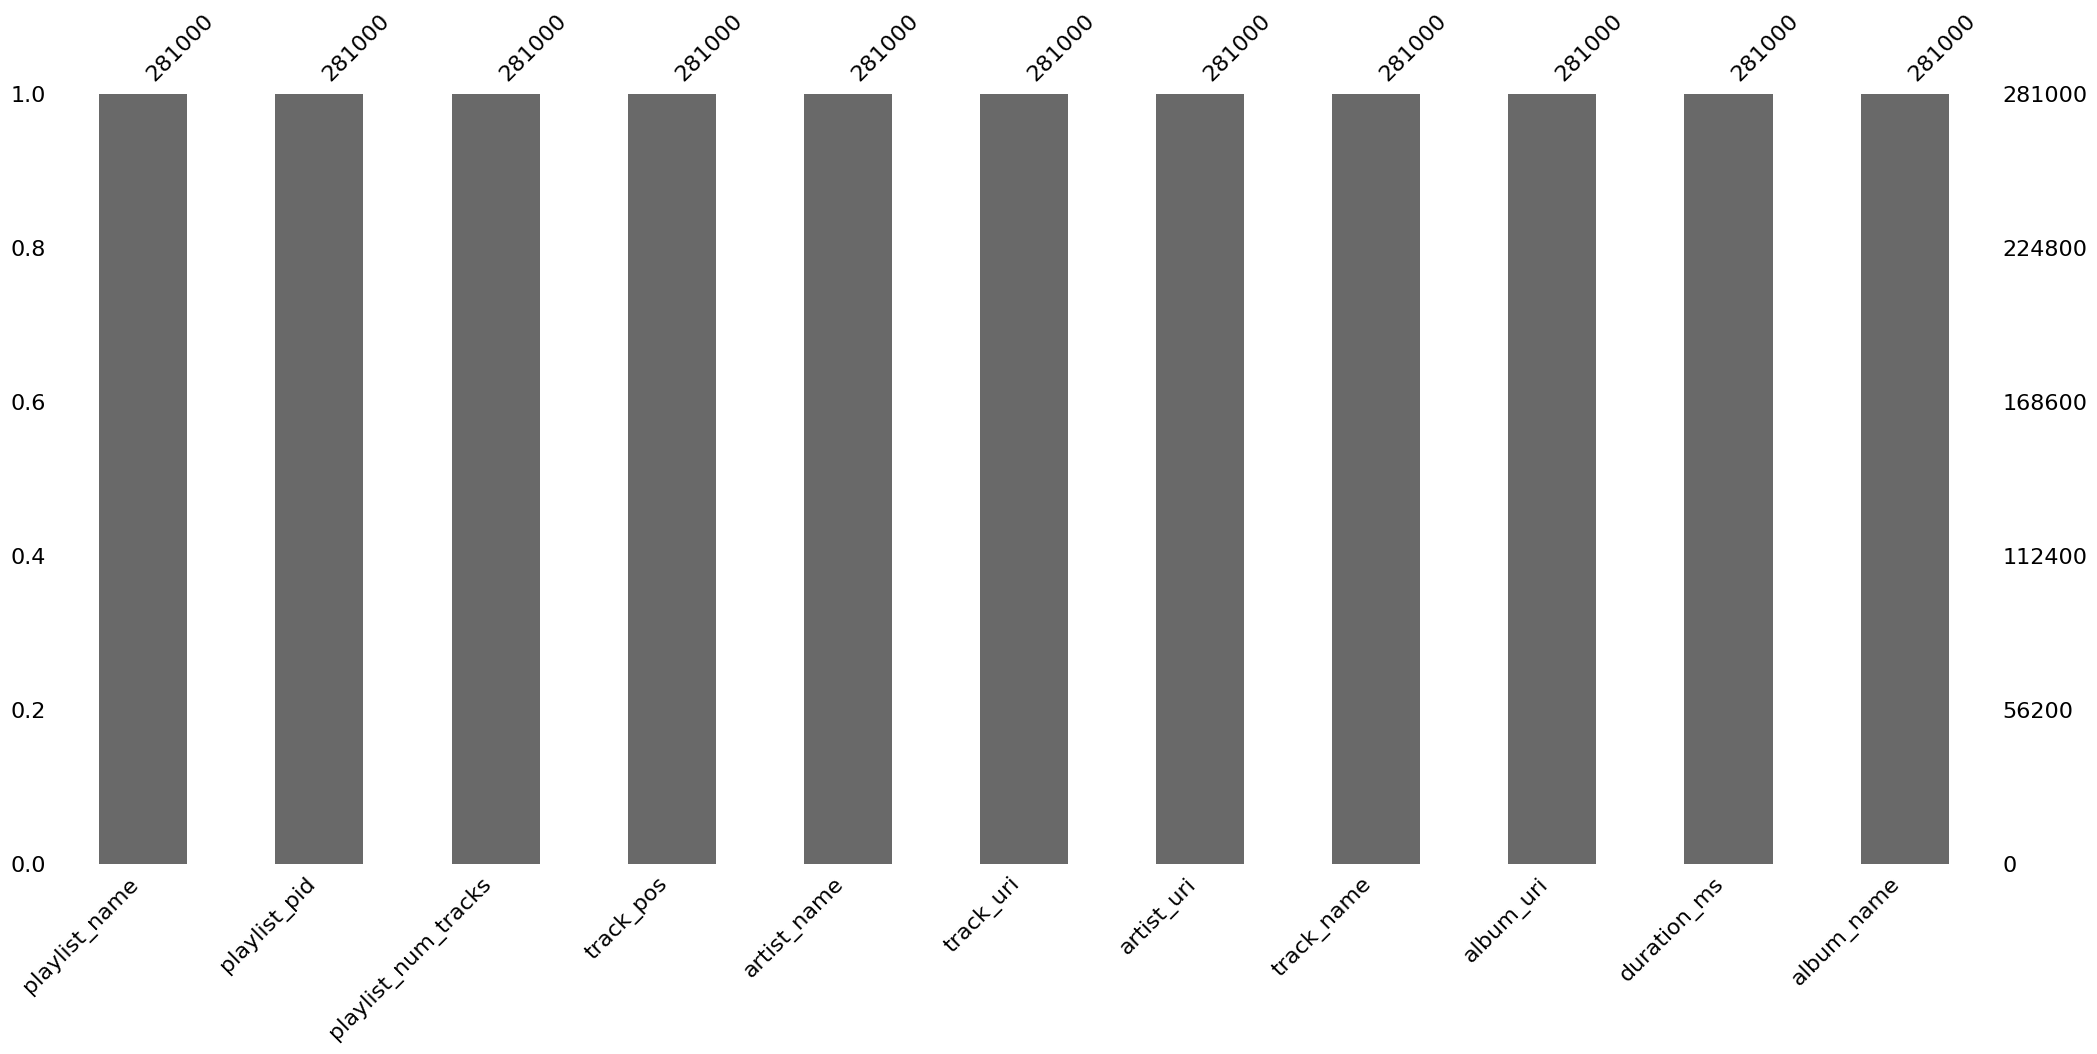

In [5]:
%matplotlib inline

msno.bar(spotify.sample(len(spotify)));

In [6]:
#Calculate missing data
spotify.isna().sum()

playlist_name          0
playlist_pid           0
playlist_num_tracks    0
track_pos              0
artist_name            0
track_uri              0
artist_uri             0
track_name             0
album_uri              0
duration_ms            0
album_name             0
dtype: int64

In [7]:
print(f'Number of playlists by id: {spotify.playlist_pid.nunique()}')
print(f'number of playlist names: {spotify.playlist_name.nunique()}')

Number of playlists by id: 9000
number of playlist names: 4227


In [8]:
spotify.playlist_pid.describe()

count    2.810000e+05
mean     1.024973e+06
std      1.406980e+04
min      1.000000e+06
25%      1.012636e+06
50%      1.025360e+06
75%      1.037128e+06
max      1.049360e+06
Name: playlist_pid, dtype: float64

----

### About paylists

#### Length of Playlists

In [9]:
spotify.groupby('playlist_pid')['duration_ms'].sum().divide(60000).round(2).describe()

count    9000.000000
mean      121.039040
std       146.503433
min         0.380000
25%        19.860000
50%        41.250000
75%       106.650000
max       796.100000
Name: duration_ms, dtype: float64

In [10]:
df_playlists_hist = pd.DataFrame(spotify.groupby('playlist_pid')['duration_ms'].sum().divide(60000).round(2)).reset_index()

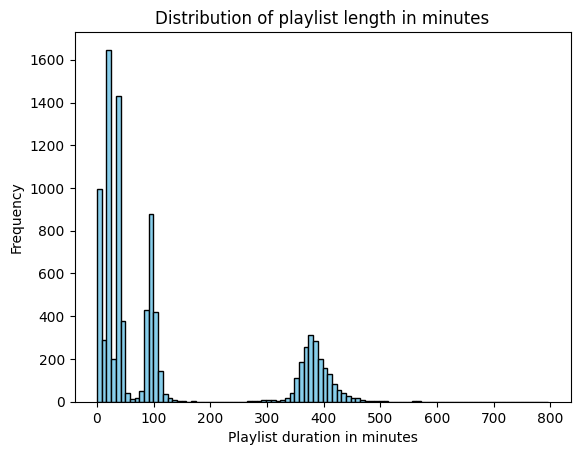

In [11]:
data = df_playlists_hist['duration_ms']
bin_edges = np.histogram_bin_edges(data, bins='fd') # Reference: https://medium.com/@maxmarkovvision/optimal-number-of-bins-for-histograms-3d7c48086fde

# Plotting histogram
plt.hist(data, bins=bin_edges, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Playlist duration in minutes')
plt.ylabel('Frequency')
plt.title('Distribution of playlist length in minutes')
 
# Display the plot
plt.show()

In [12]:
data.sort_values(ascending=False)

8292    796.10
8945    623.39
7962    617.17
8205    602.43
8634    581.29
         ...  
1933      1.64
3350      1.59
2897      1.42
2777      1.10
2356      0.38
Name: duration_ms, Length: 9000, dtype: float64

In [13]:
# Code for hist plot with density line

""" # Plot histogram with density plot
sns.histplot(data, bins=bin_edges, kde=True, color='blue', edgecolor='blue')

# Adding labels and title
plt.xlabel('Playlist duration in minutes')
plt.ylabel('Density')
plt.title('Distribution of playlist length in minutes')

# Display the plot
plt.show() """


" # Plot histogram with density plot\nsns.histplot(data, bins=bin_edges, kde=True, color='blue', edgecolor='blue')\n\n# Adding labels and title\nplt.xlabel('Playlist duration in minutes')\nplt.ylabel('Density')\nplt.title('Distribution of playlist length in minutes')\n\n# Display the plot\nplt.show() "

- The avarage playlist is 121 minutes long
- The longest playlist is 796 minutes long (that is around 13 hours)
- The shortest playlist is 0.38 minutes long

- The length of our playlists is not normally distributed but multimodal
- While most playlists are between 0 and ~123 minutes long there is another ggroup with a length of 300 to 500 minutes
----

#### How many songs are in a playlist?

In [14]:
spotify.groupby('playlist_pid')['track_uri'].count().describe() #.sum().divide(60000).round(2).describe()

count    9000.000000
mean       31.222222
std        37.607579
min         1.000000
25%         5.000000
50%        10.000000
75%        25.000000
max       100.000000
Name: track_uri, dtype: float64

In [15]:
spotify[spotify['playlist_pid'] == 1036925].shape # testing for a playlist that is supposed to have 250 songs...

(100, 11)

- On average our playlists contain 31 tracks (not checked for uniqueness)
- The smallest playlist contains 1 track
- The biggest playlist contains 100 tracks
    - This means that at least some data in 'playlist_num_tracks' are not accurate since these values start at 10 go up to 250
----

#### How many unique songs are in a playlist?

In [16]:
songs_per_playlist = spotify.groupby('playlist_pid')['track_uri'].count()
unique_songs_per_playlist = spotify.groupby('playlist_pid')['track_uri'].nunique()

ratio = unique_songs_per_playlist/songs_per_playlist
ratio.describe()

count    9000.000000
mean        0.996208
std         0.017990
min         0.600000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: track_uri, dtype: float64

In [17]:
df_ratio = pd.DataFrame(ratio)
df_ratio.sort_values('track_uri')

df_ratio.query('track_uri < 1')

track_uri
playlist_pid           
1000001            0.96
1000062            0.96
1000258            0.96
1000274            0.96
1000481            0.96
...                 ...
1049196            0.99
1049207            0.99
1049224            0.99
1049300            0.99
1049316            0.97

[1015 rows x 1 columns]

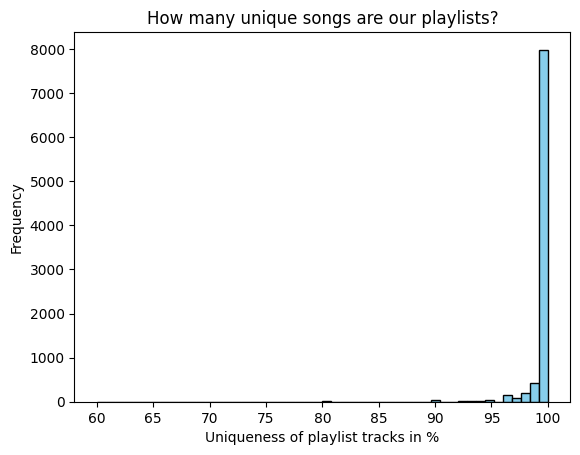

In [18]:
data = ratio

# Plotting histogram
plt.hist(data*100, bins=50, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Uniqueness of playlist tracks in %')
plt.ylabel('Frequency')
plt.title('How many unique songs are our playlists?')
 
# Display the plot
plt.show()

- On average our playlists consist of 99.62% unique songs
- There are 1015 playlists with a son-uniquness-score smaller than 100%
----

#### How many unique artists are in a playlist?

In [19]:
spotify.groupby('playlist_pid')['artist_uri'].count()


playlist_pid
1000000      5
1000001     25
1000009     25
1000016      5
1000020      5
          ... 
1049269    100
1049300    100
1049316    100
1049352    100
1049360    100
Name: artist_uri, Length: 9000, dtype: int64

In [20]:
spotify.groupby('playlist_pid')['artist_uri'].nunique()

playlist_pid
1000000     2
1000001    10
1000009     3
1000016     5
1000020     5
           ..
1049269    86
1049300    67
1049316    32
1049352    59
1049360    45
Name: artist_uri, Length: 9000, dtype: int64

In [21]:
artists_per_playlist = spotify.groupby('playlist_pid')['artist_uri'].count()
unique_artists_per_playlist = spotify.groupby('playlist_pid')['artist_uri'].nunique()

ratio = unique_artists_per_playlist/artists_per_playlist
ratio.describe()

count    9000.000000
mean        0.730019
std         0.257622
min         0.010000
25%         0.560000
50%         0.800000
75%         1.000000
max         1.000000
Name: artist_uri, dtype: float64

In [22]:
df_ratio = pd.DataFrame(ratio)
df_ratio.query('artist_uri == 1')

artist_uri
playlist_pid            
1000016              1.0
1000020              1.0
1000023              1.0
1000092              1.0
1000094              1.0
...                  ...
1014175              1.0
1014187              1.0
1014285              1.0
1026594              1.0
1030664              1.0

[2538 rows x 1 columns]

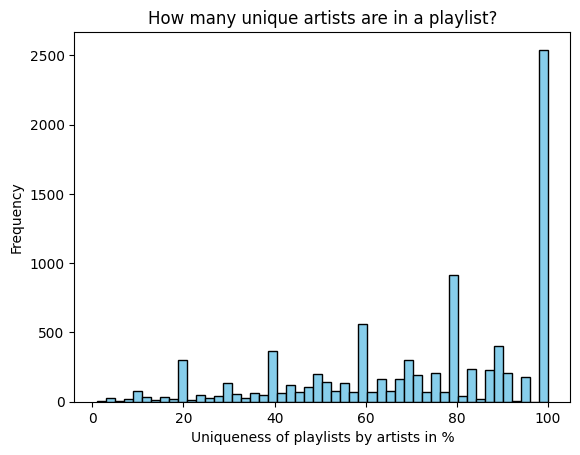

In [23]:
data = ratio

# Plotting histogram
plt.hist(data*100, bins=50, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Uniqueness of playlists by artists in %')
plt.ylabel('Frequency')
plt.title('How many unique artists are in a playlist?')
 
# Display the plot
plt.show()

- On average a playlist contains of 73% unique artists, meaning (rougly) that for every 10 songs there are 7 artists
----

#### Statistics for indiviual features

In [24]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281000 entries, 0 to 280999
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   playlist_name        281000 non-null  object
 1   playlist_pid         281000 non-null  int64 
 2   playlist_num_tracks  281000 non-null  int64 
 3   track_pos            281000 non-null  int64 
 4   artist_name          281000 non-null  object
 5   track_uri            281000 non-null  object
 6   artist_uri           281000 non-null  object
 7   track_name           281000 non-null  object
 8   album_uri            281000 non-null  object
 9   duration_ms          281000 non-null  int64 
 10  album_name           281000 non-null  object
dtypes: int64(4), object(7)
memory usage: 23.6+ MB


In [25]:
df_duration = spotify['duration_ms'].divide(60000).round(2)
df_duration

0         2.73
1         2.78
2         3.88
3         3.61
4         3.22
          ... 
280995    5.66
280996    4.75
280997    4.66
280998    3.72
280999    3.03
Name: duration_ms, Length: 281000, dtype: float64

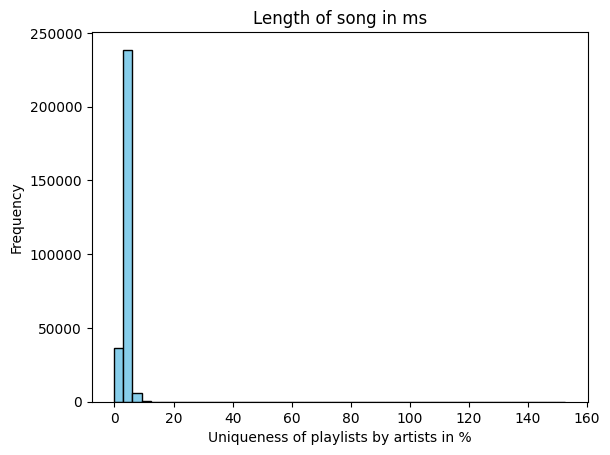

In [26]:
data = df_duration

# Plotting histogram
plt.hist(data, bins=50, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Uniqueness of playlists by artists in %')
plt.ylabel('Frequency')
plt.title('Length of song in ms')
 
# Display the plot
plt.show()

----

#### Statistics for individual features

##### How long are our songs?

In [43]:
print('Descriptive Statistics for song length in minutes')
spotify['duration_ms'].divide(60000).round(2).describe()

Descriptive Statistics for song length in minutes


count    281000.000000
mean          3.876699
std           1.052529
min           0.000000
25%           3.330000
50%           3.740000
75%           4.270000
max         152.640000
Name: duration_ms, dtype: float64

In [49]:
# Create dataframe with only unique tracks
df_duration_scatter = spotify.drop_duplicates(subset=['track_uri'])
df_duration_scatter.loc[:,'duration_ms'] = df_duration_scatter['duration_ms'].divide(60000).round(2)

# Plot scatter for song length
import plotly.express as px 
fig = px.scatter(df_duration_scatter, y="track_uri", x="duration_ms", color='playlist_pid')
fig.show()


In [50]:
df_duration_scatter.query('duration_ms > 50')

playlist_name  playlist_pid  playlist_num_tracks  track_pos   
157388  coachella 2015       1028166                  218         88  \
200539         Dubstep       1035596                  218         84   
209275      Dance Jams       1037017                  228        167   
209276      Dance Jams       1037017                  228        168   
209277      Dance Jams       1037017                  228        169   
209278      Dance Jams       1037017                  228        170   
236265              DJ       1041673                  159        109   
254631      R E L A X        1044999                  162         55   

                  artist_name                             track_uri   
157388          Gesaffelstein  spotify:track:6N3BEQOuCDf701cMMMfKMn  \
200539               deadmau5  spotify:track:5SBLB7hnQGD2pS6CGrpcA7   
209275             Monstercat  spotify:track:4VrdksXJVhAOLW49qV0VTQ   
209276             Monstercat  spotify:track:4mjgNE8R31AzxWfPNGtVMf   
209277             Monstercat  spotify:track:6tAM5c0bJOwRqGAEgiNMpI   
209278             Monstercat  spotify:track:5CmMyiq4um2aFhiLZ1rPWo   
236265             Bassnectar  spotify:track:39yKCAY1AE4N6f6BfN18lf   
254631  Ocean Waves For Sleep  spotify:track:1saXdvEAafdRzUphXBzSHg   

                                   artist_uri   
157388  spotify:artist:3hteYQFiMFbJY7wS0xDymP  \
200539  spotify:artist:2CIMQHirSU0MQqyYHq0eOx   
209275  spotify:artist:4YwB41gFHCxY5bcNR3CcIH   
209276  spotify:artist:4YwB41gFHCxY5bcNR3CcIH   
209277  spotify:artist:4YwB41gFHCxY5bcNR3CcIH   
209278  spotify:artist:4YwB41gFHCxY5bcNR3CcIH   
236265  spotify:artist:1JPy5PsJtkhftfdr6saN2i   
254631  spotify:artist:2CgVSpL4tfbUuHmTGS7wF3   

                                 track_name   
157388  I Love Techno 2013 - Continuous Mix  \
200539              4x4=12 - Continuous Mix   
209275    Best of 2014 (Album Mix - Part 1)   
209276             Best of 2015 (Album Mix)   
209277                     Solace Album Mix   
209278             Best of 2016 (Album Mix)   
236265                           Mixtape 13   
254631                Ocean Waves for Sleep   

                                   album_uri  duration_ms   
157388  spotify:album:4fkD70biXjgokqcHdO0PRV        50.95  \
200539  spotify:album:54i5h9uR3KCdFif3mBvSqm        69.92   
209275  spotify:album:5cOXQYVy3Hvlu2xBpL4dD2        56.24   
209276  spotify:album:3VPfZq2GlqDTZqjZHPmHIw       152.64   
209277  spotify:album:7dArkHuO5wkus2TJTu6Ytx        58.98   
209278  spotify:album:5Zt1P3ZbnfErBkiqcfBTCN       152.44   
236265  spotify:album:29e92rWX8k9EYyhi3COxtE        71.27   
254631  spotify:album:5GUt6Nv1JP1H80sLXZWzg0        68.67   

                       album_name  
157388         I Love Techno 2013  
200539                     4x4=12  
209275  Monstercat - Best of 2014  
209276   Monstercat: Best of 2015  
209277    Monstercat 007 - Solace  
209278  Monstercat - Best of 2016  
236265               Into the Sun  
254631                Ocean Waves

- Average song length is just under 4 minutes
----

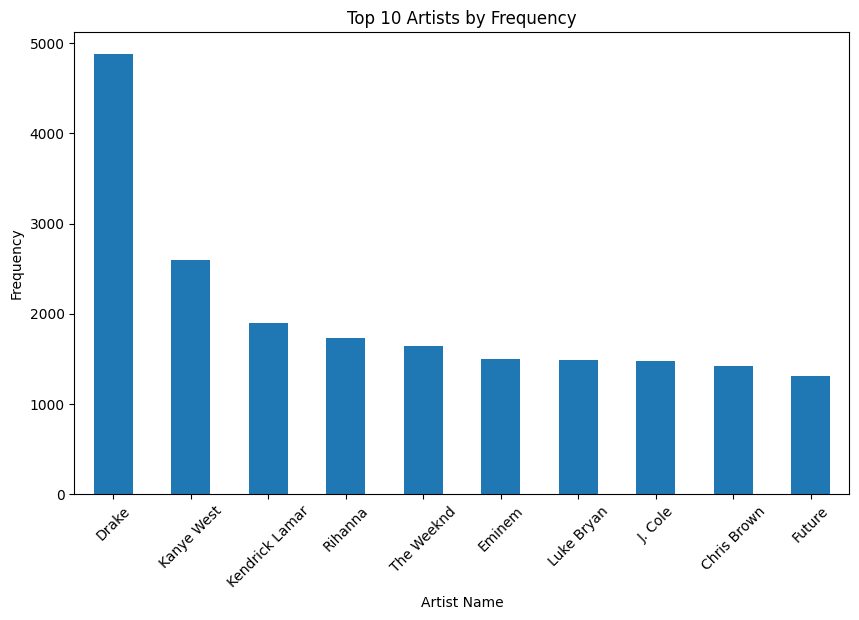

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'spotify' is your DataFrame
top_artists = spotify.groupby('artist_uri').size().sort_values(ascending=False).head(10)
top_artist_names = spotify.groupby('artist_uri')['artist_name'].first().loc[top_artists.index]

# Plotting
plt.figure(figsize=(10, 6))
top_artists.plot(kind='bar')
plt.xticks(range(len(top_artist_names)), top_artist_names, rotation=45)
plt.xlabel('Artist Name')
plt.ylabel('Frequency')
plt.title('Top 10 Artists by Frequency')
plt.show()

# Conslusions

## Repair/repair data

- Remove 'playlist_num_tracks'
    - doesn't contain relevant information
- Remove IDs or real names to avoid correlation (?) -> if algorithm can't handle correlation
- Remove songs with duration of 0
- Remove songs longer than 50 minutes
- Remove playlists that contain too many non-unique songs (see 'How many unique songs are in a playlist')
- Remove very long and very short playlists (see 'Length of playlists') (???)